In [1]:
import sys


sys.path.append("../src/")

In [14]:
from sennet.custom_modules.metrics.surface_dice_metric_fast import create_table_neighbour_code_to_surface_area
import torch
import matplotlib.pyplot as plt
import numpy as np

In [3]:
device = "cpu"


unfold = torch.nn.Unfold(kernel_size=(2, 2), padding=1)


area = create_table_neighbour_code_to_surface_area((1, 1, 1))[1:]
area = torch.from_numpy(area).to(device)  # torch.float32
area.shape

torch.Size([255])

bases_vals.shape=(8, 255)
bases.shape=torch.Size([8, 255])


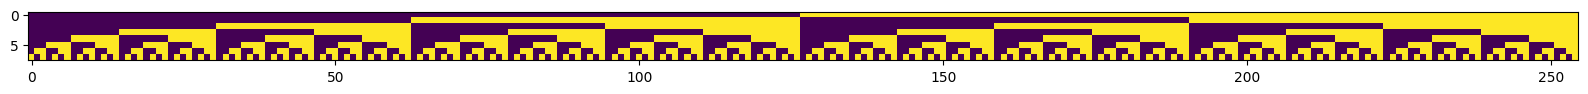

In [18]:
bases_vals = np.array([
    [c=="1" for c in f"{i:08b}"]
    for i in range(1, 256)
]).transpose()
bases = torch.from_numpy(bases_vals).float().to(device)
print(f"{bases_vals.shape=}")
print(f"{bases.shape=}")

plt.figure(figsize=(20, 10))
plt.imshow(bases_vals)

In [19]:
batch_size = 1
zs = 2
ys = 3
xs = 3

# pred = torch.rand((batch_size, zs, ys, xs)).to(device)
labels = (torch.rand((batch_size, zs, ys, xs)) > 0.5).to(device)

pred = labels.float()   # sanity check to see if loss will be 0

In [20]:
unfolded_pred = unfold(pred)
unfolded_labels = unfold(labels.float())

permuted_unfolded_pred = unfolded_pred.permute((0, 2, 1)).unsqueeze(-1)
permuted_unfolded_labels = unfolded_labels.permute((0, 2, 1)).unsqueeze(-1)

print(f"{unfolded_pred.shape=}")
print(f"{unfolded_labels.shape=}")
print(f"{permuted_unfolded_pred.shape=}")
print(f"{permuted_unfolded_labels.shape=}")

unfolded_pred.shape=torch.Size([1, 8, 16])
unfolded_labels.shape=torch.Size([1, 8, 16])
permuted_unfolded_pred.shape=torch.Size([1, 16, 8, 1])
permuted_unfolded_labels.shape=torch.Size([1, 16, 8, 1])


In [21]:
batch_size, n_points, n_corners, _ = permuted_unfolded_pred.shape
assert n_corners == 8, f"{n_corners=} == 8, are you working on 2 slices?"

a_mat = bases.tile((batch_size, n_points, 1, 1))
b_mat = permuted_unfolded_pred
lstsq_soln = torch.linalg.lstsq(a_mat, b_mat)
bases_weights = lstsq_soln.solution

# for each batch and point, get weights such that 
#    corner_type @ weights = the_predicted_8_corners

print(f"{a_mat.shape = }")   # batch, n_points, n_corners, n_bases
print(f"{b_mat.shape = }")   # batch, n_points, n_corners, 1
print(f"{bases_weights.shape = }")  # batch, n_points, n_bases, 1
print((a_mat @ bases_weights).shape)
print("residual each point: ", (a_mat @ bases_weights - b_mat).abs().sum(-1).sum(-1))
for b in b_mat.squeeze(0).squeeze(-1):
    print(b)

a_mat.shape = torch.Size([1, 16, 8, 255])
b_mat.shape = torch.Size([1, 16, 8, 1])
bases_weights.shape = torch.Size([1, 16, 255, 1])
torch.Size([1, 16, 8, 1])
residual each point:  tensor([[1.0000, 2.3333, 4.0000, 2.0000, 1.0000, 3.0000, 3.3333, 2.0000, 2.3333,
         3.0000, 3.0000, 1.0000, 2.0000, 3.0000, 1.0000, 0.0000]])
tensor([0., 0., 0., 1., 0., 0., 0., 0.])
tensor([0., 0., 1., 0., 0., 0., 0., 1.])
tensor([0., 0., 0., 0., 0., 0., 1., 1.])
tensor([0., 0., 0., 0., 0., 0., 1., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0.])
tensor([1., 0., 0., 1., 0., 1., 0., 1.])
tensor([0., 0., 1., 1., 1., 1., 1., 0.])
tensor([0., 0., 1., 0., 1., 0., 0., 0.])
tensor([0., 0., 0., 1., 0., 0., 0., 1.])
tensor([0., 1., 1., 0., 0., 1., 1., 1.])
tensor([1., 1., 0., 0., 1., 0., 1., 0.])
tensor([1., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 1., 0., 0.])
tensor([1., 0., 0., 0., 1., 1., 0., 0.])
tensor([0., 0., 0., 0., 1., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0.])


In [ ]:
lstsq_soln

In [ ]:
print(bases_weights.shape)
print(area.shape)

In [ ]:
pred_areas = (area[None, None, :, None] * bases_weights).squeeze(-1).sum(2)
print(pred_areas.shape)

In [ ]:
label_cubes_byte = torch.zeros((unfolded_labels.shape[0], unfolded_labels.shape[2]), dtype=torch.int32, device=device)
for k in range(8):
    label_cubes_byte += unfolded_labels[:, k, :].to(torch.int32) << k
print(f"{unfolded_labels.shape = }")
print(f"{label_cubes_byte.shape = }")

In [ ]:
label_areas = torch.zeros((label_cubes_byte.shape[0], label_cubes_byte.shape[1]), dtype=torch.float32, device=device)
for b in range(label_cubes_byte.shape[0]):
    label_areas[b, :] = torch.where(label_cubes_byte[b, :] == 0, label_areas[b, :], area[label_cubes_byte[b, :] - 1])
label_areas.shape

### sanity check for when pred == label, areas should equal

In [ ]:
squeezed_base_weights = bases_weights.squeeze(0).squeeze(-1)  # useful when batch size == 1
squeezed_permuted_unfolded_pred = permuted_unfolded_pred.squeeze(0).squeeze(-1)

print(f"{squeezed_base_weights.shape = }")
print(f"{squeezed_permuted_unfolded_pred.shape = }")
print(f"{bases.shape = }")

torch.abs(squeezed_base_weights @ bases.permute((1, 0)) - squeezed_permuted_unfolded_pred).sum()

In [ ]:
# check that computed pred cube matches label cubes

base_weights_max = squeezed_base_weights.max(1)
base_weights_max_vals = base_weights_max.values
base_weights_max_indices = base_weights_max.indices + 1

print(bases_weights.shape)
print()
print(f"pred_cube_byte: {base_weights_max_indices}")
print()
print(f"pred_cube_weights: {base_weights_max_vals}")
print()
print(f"label_cubes_byte: {label_cubes_byte}")

In [ ]:
label_areas.reshape(-1)

In [ ]:
pred_areas.reshape(-1)

### this is from dice loss
```python
def forward(self, input, target):
    # Apply sigmoid to input (predictions)
    input_sigmoid = torch.sigmoid(input).reshape(-1)
    target_flat = target.reshape(-1)
    
    intersection = (input_sigmoid * target_flat).sum()

    return 1 - (
        (2.0 * intersection + self.smooth)
        / (input_sigmoid.sum() + target_flat.sum() + self.smooth)
    )
```

In [ ]:
# batch, cube
label_cubes_byte.shape

In [ ]:
# batch, point, weights, 1
bases_weights.shape

In [ ]:
# batch, point
label_areas.shape

In [ ]:
# intersection = use the base weights (255 items), 
#   then go and get the weighted sum of the label areas at each pixel
#   - so you need to know which cube hits the label
#   - then take the area of that guy

intersection = torch.zeros((bases_weights.shape[0], bases_weights.shape[1]), device=device, dtype=torch.float32)
for i in range(bases_weights.shape[0]):
    w = bases_weights[i, ...].squeeze(-1)  # (points, 255)
    cb = label_cubes_byte[i, ...]   # (points, )
    weight_at_label_cube = torch.where(
        cb==0, 
        torch.zeros((w.shape[0], ), dtype=torch.float32, device=device), 
        w[torch.arange(w.shape[0], device=device), cb-1]
    )
    # print(cb.shape, w.shape, weight_at_label_cube.shape)
    intersection[i, ...] = weight_at_label_cube * label_areas[i, ...]

In [ ]:
intersection.shape

In [ ]:
smooth = 1e-3
numerator = 2 * intersection.sum()
denominator = label_areas.sum() + pred_areas.sum()
dice = 1 - ((numerator + smooth) / (denominator + smooth))

print(f"{intersection.sum() = }")
print(f"{label_areas.sum() = }")
print(f"{pred_areas.sum() = }")
print(f"{numerator = }")
print(f"{denominator = }")
print(f"{dice = }")

In [ ]:
pred_areas

In [ ]:
unfolded_labels.shape

In [ ]:
smooth = 1e-3
numerator = 
denominator = pred_areas.sum() + 

In [ ]:
pred_areas.shape

In [ ]:
torch.abs(torch.sum(permuted_unfolded_pred))

In [ ]:
torch.abs(torch.sum(a_mat))

In [ ]:
a = bases
# b = permuted_unfolded_pred[0, 0]
b = a[:, 0]
print(f"{a.shape = }")
print(f"{b.shape = }")
print(a)
print(b)
sol = torch.linalg.lstsq(bases, b)
print(sol.rank)
print(sol.solution.reshape(-1))

In [ ]:
torch.linalg.matrix_rank(a)

In [ ]:
a_np = a.cpu().numpy()
b_np = b.cpu().numpy()

weights, residuals, rank, singular_vals = np.linalg.lstsq(a_np, b_np, rcond=None)

print(a_np.shape)
print(b_np.shape)
print(b_np)
print(np.sum(np.abs(weights)))
print(residuals)
print(rank)
print(singular_vals)

In [ ]:
for i in range(256):
    print(a_np[:, i])

In [29]:
import torch


unfold = torch.nn.Unfold(kernel_size=(2, 2), padding=1)

In [31]:
a = (torch.arange(8)+1).reshape((2, 2, 2)).float()
ua = unfold(a.unsqueeze(0))[0]
print(a.shape)
print(ua.shape)

torch.Size([2, 2, 2])
torch.Size([8, 9])


In [34]:
ua[:, 0]

tensor([0., 0., 0., 1., 0., 0., 0., 5.])

In [33]:
a

tensor([[[1., 2.],
         [3., 4.]],

        [[5., 6.],
         [7., 8.]]])